# Saliency

Like class activation maps, saliency maps also tells us what parts of the image the model is focusing on when making its predictions.

- The main difference is in saliency maps, we are just shown the relevant pixels instead of the learned features.
- You can generate saliency maps by getting the gradient of the loss with respect to the image pixels.
- This means that changes in certain pixels that strongly affect the loss will be shown brightly in your saliency map.


https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/3-Advance_computer_vision/week-4/C3_W4_Lab_3_Saliency.ipynb

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# For the classifier, you will use the Inception V3 model available in Tensorflow Hub.
# This has pre-trained weights that is able to detect 1001 classes. You can read more here.
# https://tfhub.dev/google/tf2-preview/inception_v3/classification/4

model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [4]:
# tabby cat
#!wget -O image2.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# husky
# If you want to try the cat, uncomment this line
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg


--2022-01-27 04:55:28--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211346 (206K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 206.39K  --.-KB/s    in 0.05s   

2022-01-27 04:55:29 (4.26 MB/s) - ‘image.jpg’ saved [211346/211346]



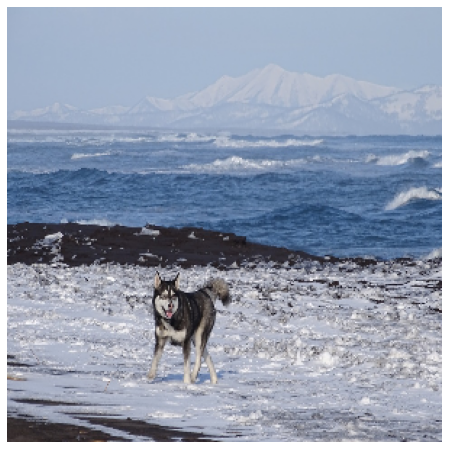

In [6]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
# You will now get the gradients of the loss with respect to the input image pixels.
#  This is the key step to generate the map later.

# Siberian Husky's class ID in ImageNet
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# image.shape is (1, 300, 300, 3)

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    tape.watch(inputs)

    predictions = model(inputs)

    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
# derivative of loss with respect to inputs
# ie d_loss/d_inputs
# this works because it tells us that the
# loss changes on which input img pixels
gradients = tape.gradient(loss, inputs) 

In [12]:
# let's visualize the results 

# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)


In [13]:
# Let's do a little sanity check to see the results of the conversion.

# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

'''


You should get something like:

1.2167013
0.0

(203, 129)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


'''

1.2237763
0.0

(203, 129)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


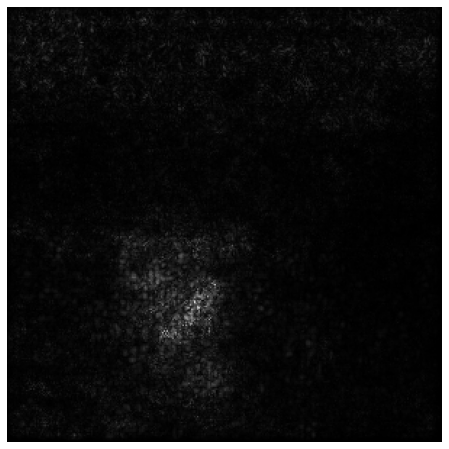

these are the pixels that activated, so this region in the image are what's responsible for prediction


In [18]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()
print("these are the pixels that activated, so this region in the image are what's responsible for prediction")

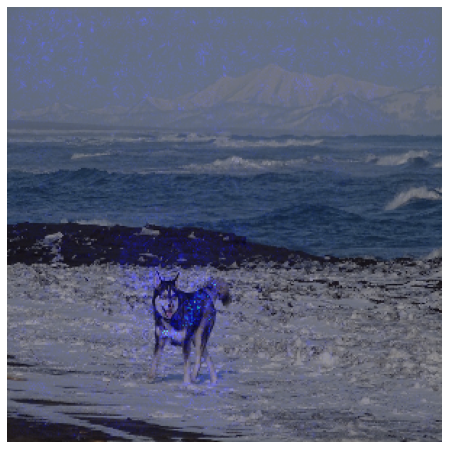

In [19]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.6, gradient_color, 0.6, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()